### some feature selection

### Makin models from all the features

I make sure that columns are the right data types and fill nan values with the appropriate values. I also made season and reno columns. season is categorical and contains what season the sale happened in. reno is 1 for has been renovated and 0 for hasn't been renovated. I did a linear regression with and without a polynomial features. I also tried SGD and decision tree. I think that SGD and decision tree aren't better and take a while to run. I'm just gonna stick with the first two. I made an error before loading the other models to the notebook stops running after the polynomial features linear regression.

### Feature Selection

This new model uses some feature selection to pick the best features to use in the model. I also tried imputing missing values and using polynomial features. I didn't expect imputing to do anything because I had already replaced missing values. I don't think that I am using polynomial features correctly and that is why it looks like it isn't doiing anything.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


In [2]:
df = pd.read_csv('cleaned_df',index_col=0)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,reno
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,1
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,1
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,1
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,1
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,1


In [3]:
df.drop('id',axis=1,inplace=True)

In [4]:
df['reno'].loc[df['yr_renovated'] == 0] = 0
df['date'] = df['date'].map(lambda x: x.split('/'))
df['year'] = df['date'].map(lambda x: x[2])
df['day'] = df['date'].map(lambda x: x[1])
df['month'] = df['date'].map(lambda x: x[0])
df['day'] = df['day'].astype(float)
df['year'] = df['year'].astype(float)
df['month'] = df['month'].astype(float)
df.drop('date',inplace=True,axis=1)
df['season'] = 's'
df['season'].loc[ (df['month'] == 6) | (df['month'] == 7) | (df['month'] == 8)] ='summer'
df['season'].loc[ (df['month'] == 9) | (df['month'] == 10) | (df['month'] == 11)] ='fall'
df['season'].loc[ (df['month'] == 12) | (df['month'] == 1) | (df['month'] == 2)] ='winter'
df['season'].loc[ (df['month'] == 3) | (df['month'] == 4) | (df['month'] == 5)] ='spring'

df['sqft_living_times_grade'] = df['sqft_living'] * df['grade']
df['condition_div_grade'] = df['condition'] / df['grade']
df['sqft_living_sq'] = df['sqft_living']**2
df['bathrooms_sq'] = df['bathrooms']**2

C:\Users\umbac\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\umbac\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\umbac\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2,interaction_only=True)


In [34]:
categoricals = ['bedrooms','bathrooms','waterfront','floors','view','grade','condition','zipcode']
continuous = ['price','sqft_living_sq','sqft_lot','sqft_above','sqft_basement','yr_built','lat','long','sqft_living15','sqft_lot15','month','year','yr_renovated']

df_cont = df[continuous]


In [35]:
df_ohe = pd.get_dummies(df[categoricals])

preprocessed = pd.concat([df_cont, df_ohe],axis=1)



X = preprocessed.drop('price',axis=1)


imp_mean = SimpleImputer(missing_values = np.nan, strategy='mean')
imp_mean.fit_transform(X)



scale = StandardScaler()

X = scale.fit_transform(X)

X = pd.DataFrame(X)

y = preprocessed['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [36]:
X_train = poly.fit_transform(X_train,y_train)
X_test = poly.fit_transform(X_test,y_test)


In [37]:
linreg = LinearRegression()

In [38]:
#use the best 10 features
selector = RFE(linreg, n_features_to_select=15, step=1)
selector = selector.fit(X_test, y_test)

In [39]:
y_hat_train = selector.predict(X_train)
y_hat_test = selector.predict(X_test)

In [40]:
split_score = r2_score(y_test, y_hat_test)
split_score.mean()

0.1410566008742129

In [41]:
RMSE_test = mean_squared_error(y_test,y_hat_test,squared=False)
RMSE_train = mean_squared_error(y_train,y_hat_train,squared=False)
RMSE_diff = abs(RMSE_test - RMSE_train)
RMSE_diff
# RMSE_test,RMSE_train

18127.926698845928

In [42]:
cv = KFold(n_splits=5,shuffle=True)
cv_score = cross_val_score(linreg,X_test,y_test,scoring='r2',cv=cv)
cv_score.mean()

-4.330758418040494e+22

In [43]:
selector.ranking_

array([ 364,  358,  355, ..., 1280, 1142, 1066])

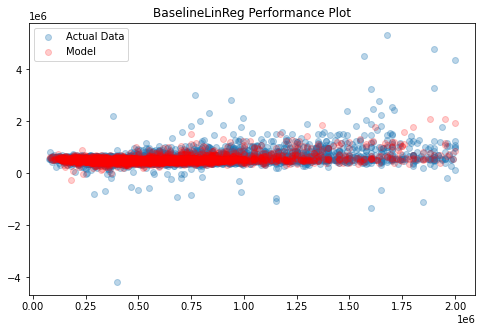

In [44]:
plt.figure(figsize=(8, 5))
plt.scatter(y_train, y_hat_train, label='Actual Data',alpha = 0.3)
plt.scatter(y_test, y_hat_test, label='Model',alpha = 0.2,c='r')
plt.title('BaselineLinReg Performance Plot')
plt.legend();

In [45]:
#kbest
# from sklearn.feature_selection import SelectKBest, chi2

In [24]:
# df_ohe = pd.get_dummies(df[categoricals])

# preprocessed = pd.concat([df_cont, df_ohe],axis=1)



# X = preprocessed.drop('price',axis=1)


# imp_mean = SimpleImputer(strategy='mean')
# imp_mean.fit_transform(X)



# scale = StandardScaler()

# X = scale.fit_transform(X)

# X = pd.DataFrame(X)

# y = preprocessed['price']


# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
# linreg = LinearRegression()

In [ ]:
#use the best
#non-negative input?
#X_best = SelectKBest(chi2, k=10).fit_transform(X_train,y_train)
